# Imputing Age

In [14]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
agena = data[data.Age.isnull()]
agedata = data[~data.Age.isnull()]
agedata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


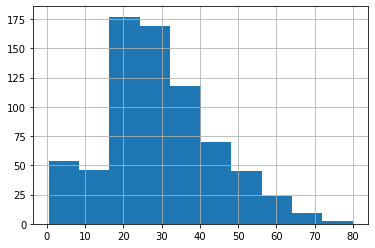

In [3]:
data.Age.hist()

### Note3:
I think number of siblings or parents/children can defintely tell something about the age group of a person. The remaining variables that make a little to no sense are {Pclass, sex, Fare}

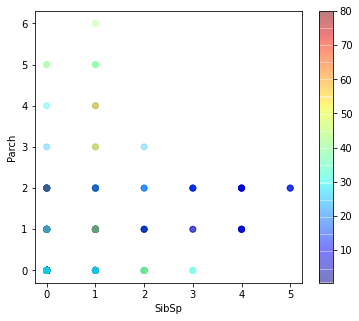

In [38]:
fig, ax = plt.subplots(figsize=(6,5))

ax.scatter(agedata.SibSp, agedata.Parch, c=agedata.Age, cmap=plt.get_cmap('jet'), alpha=0.3)
pcm = ax.get_children()[0]
ax.set_xlabel('SibSp')
ax.set_ylabel('Parch')
plt.colorbar(pcm, ax=ax)

In [37]:
print(sum(agedata.Age > 60))
print(agedata.shape)

22
(714, 12)


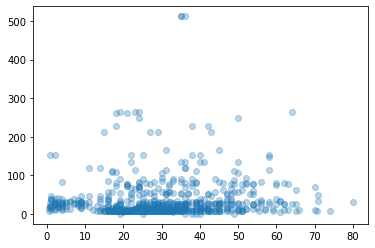

In [39]:
plt.scatter(agedata.Age, agedata.Fare, alpha=0.3)

([<matplotlib.axis.XTick at 0x28abfe20c88>,
 <a list of 3 Text major ticklabel objects>)

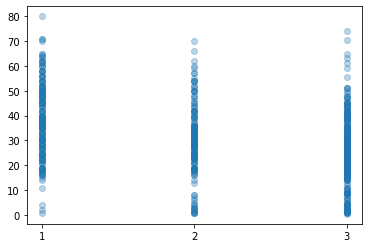

In [15]:
from sklearn.model_selection import train_test_split

agedata = agedata[agedata.Age < 60]
X = agedata[['SibSp', 'Parch']]
X['high_fare'] = agedata.Fare > 200
y = agedata.Survived

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

param_grid = [
    {'n_estimators': [100, 150, 200], 'max_depth': [2, 3], 'max_leaf_nodes': [4, 5, 6, 7]},
]

xgb = XGBRegressor()

grids = GridSearchCV(xgb, param_grid, scoring="neg_mean_squared_error", return_train_score=True, cv=5)
grids.fit(X, y)

joblib.dump(grid.best_estimator_, 'filename.pkl')